#TIME SERIES ANALYSIS

#Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

##DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [1]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are available to you as a python data cube here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy.


#Task 1: 
##Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
##Identify it and figure out what it is due to.


In [2]:
import pylab as pl
import numpy as np
import pandas as pd
import json
import os
import operator
import matplotlib.pylab 
#import matplotlib.gridspec as gridspec
%matplotlib inline
#import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = np.load('MTA_Fare.npy')

#data = np.load('/Users/carlyle/Downloads/MTA_Fare (3).npy')
data = np.where(data ==-1,np.nan,data)

In [4]:
#sum up data to get rides by station
df = pd.DataFrame(np.nansum(data, axis=1).transpose())
df.index = pd.Index(pd.date_range(pd.to_datetime('05/21/2010'), pd.to_datetime('02/07/2014'),freq='W'))

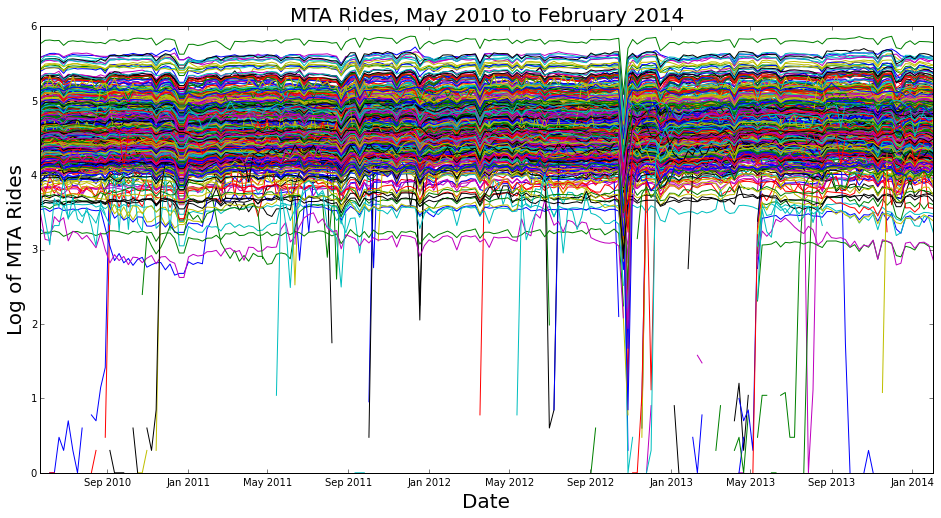

In [5]:
pl.figure(figsize=(16,8))
pl.plot(df.index, np.log10(df))
pl.xlabel('Date', fontsize=20)
pl.ylabel('Log of MTA Rides', fontsize=20)
pl.title('MTA Rides, May 2010 to February 2014', fontsize=20)

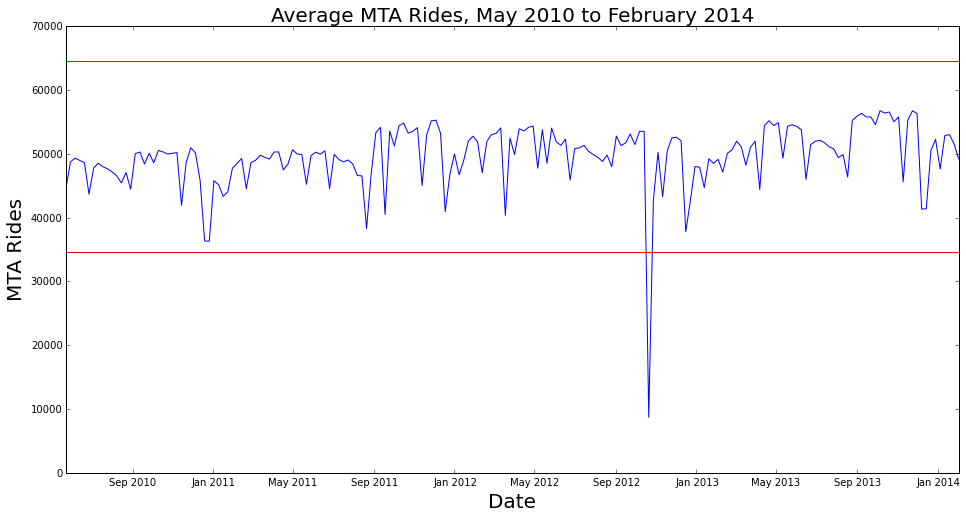

In [6]:
#get mean ridership across all stations

df_mean = df.mean(axis=1)

thresholds = [df_mean.mean() + 3*df_mean.std(), df_mean.mean() - 3*df_mean.std()]

pl.figure(figsize=(16,8))
pl.plot(df_mean.index, df_mean)
pl.axhline(thresholds[0], color = 'r')
pl.axhline(thresholds[1], color = 'r')
pl.xlabel('Date', fontsize=20)
pl.ylabel('MTA Rides', fontsize=20)
pl.title('Average MTA Rides, May 2010 to February 2014', fontsize=20)

In [7]:
print('Events less than 3 SD from the mean happened during the following weeks: ',
      df_mean[df_mean < thresholds[1]].index[0])

Events less than 3 SD from the mean happened during the following weeks:  2012-10-21 00:00:00


**This event is Hurricane Sandy**

#Task 2: 
##Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)



In [8]:
ridetype = ['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud']
#get ridership by rider type
df2 = pd.DataFrame(np.nansum(data, axis=0).transpose(), columns = ridetype)
df2.index = pd.Index(pd.date_range(pd.to_datetime('05/21/2010'), pd.to_datetime('02/07/2014'),freq='W'))


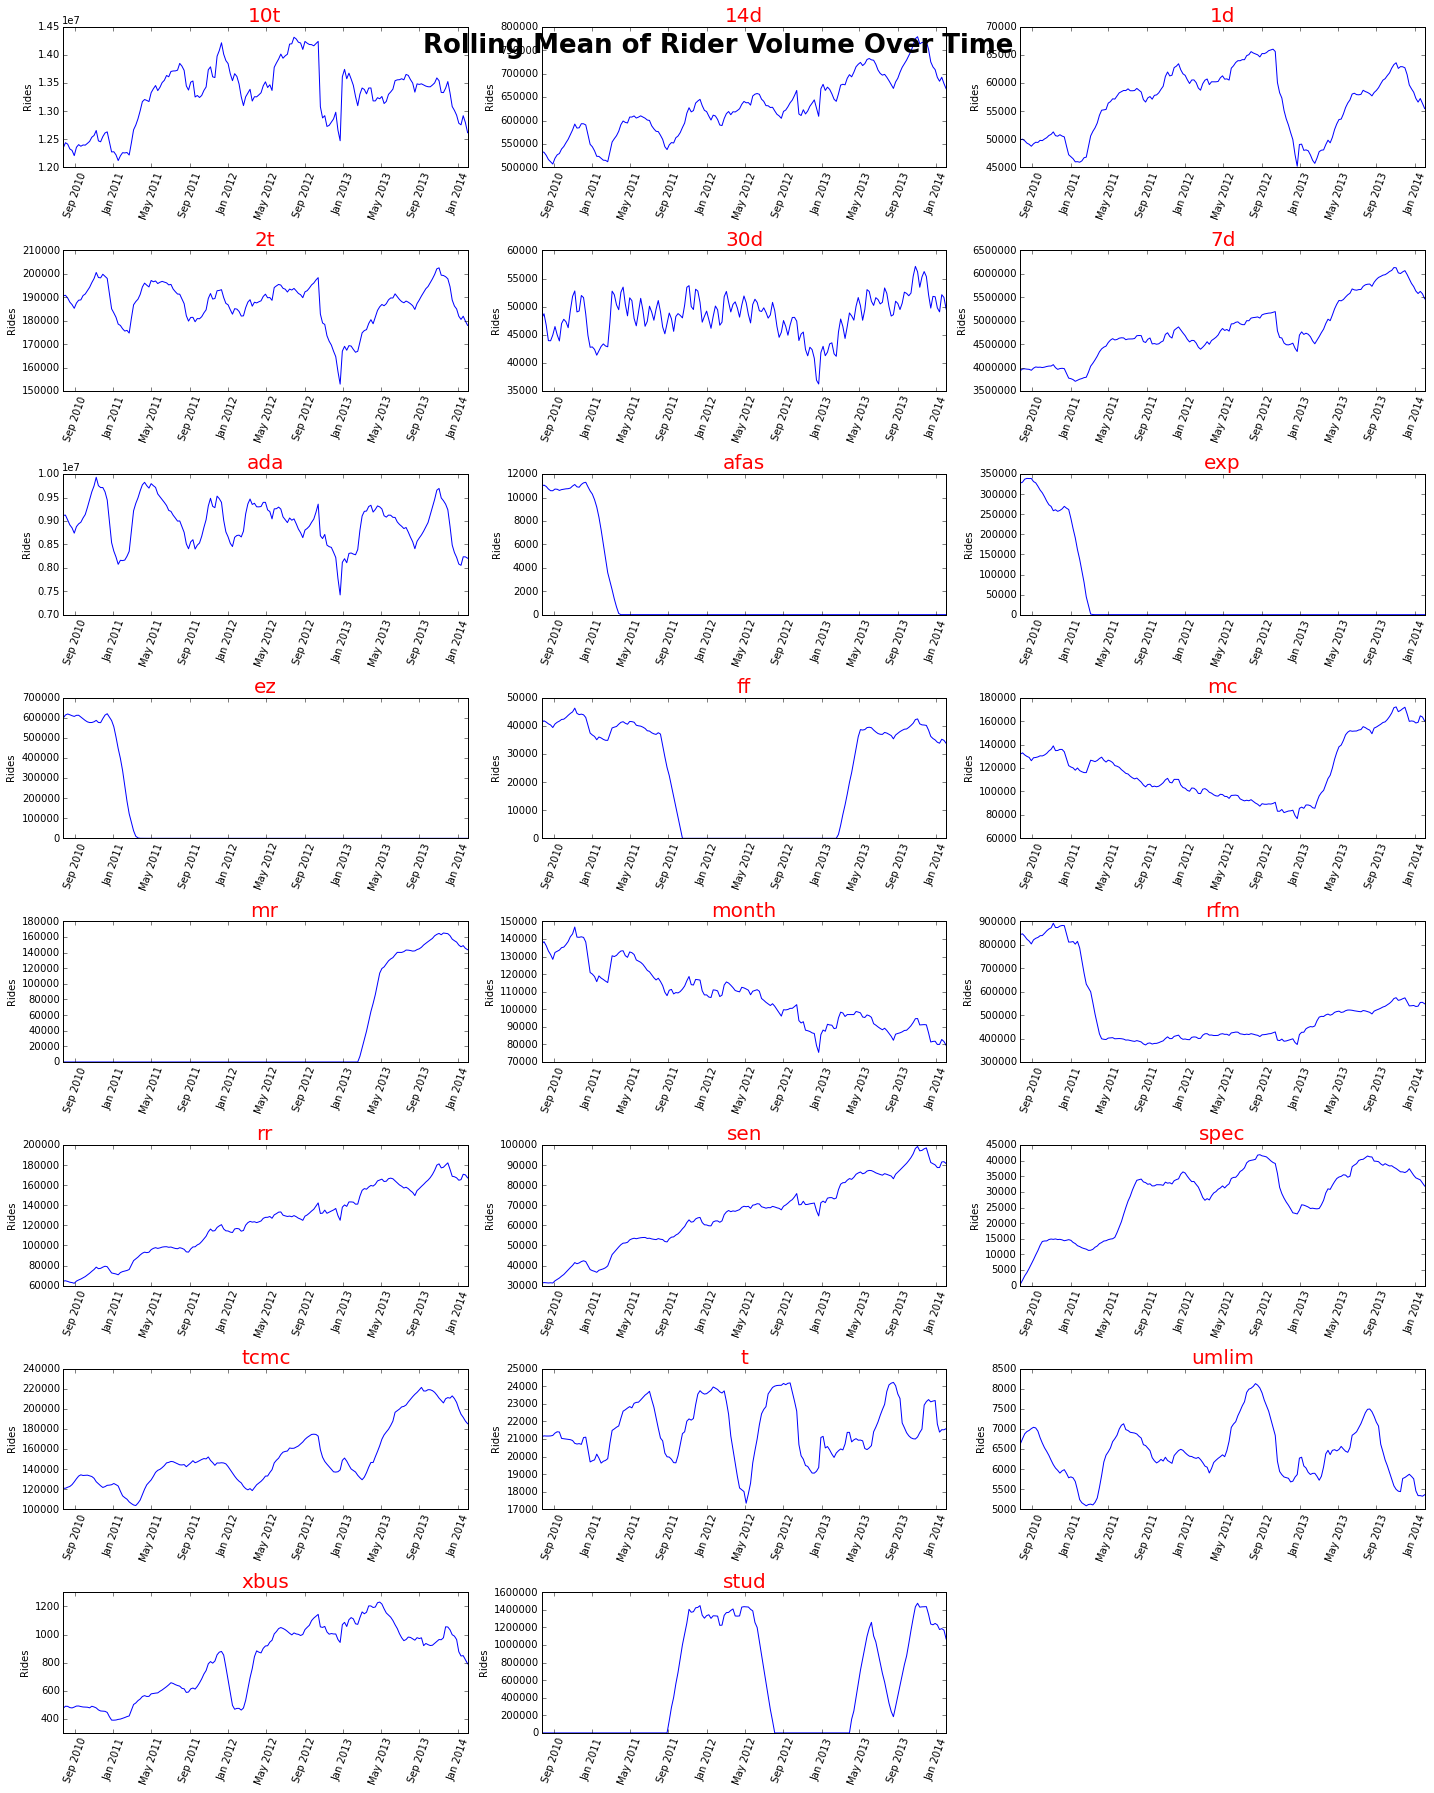

In [9]:
fig = pl.figure(figsize=(20,25))
fig.suptitle('Rolling Mean of Rider Volume Over Time', fontweight='bold', fontsize=26)

x = 1
for ride_type in df2.columns:
    y = pd.rolling_mean(df2[ride_type], 10)
    ax1 = fig.add_subplot(8,3,x)
    fig.tight_layout()
    ax1.plot(df2.index, y)
    ax1.set_ylabel("Rides")
    plt.xticks(rotation = 70)
    ax1.set_title(ride_type, fontsize=20, color='r')
    x +=1

In [10]:
# Flux Ratio for first 10 weeks / last 10 weeks
for ride_type in df2.columns:
    flux = df2[ride_type].head(10).mean()/df2[ride_type].tail(10).mean()
    print ('flux ratio beginning to end for {0}: {1:.3f}'.format(ride_type, flux))


flux ratio beginning to end for 10t: 0.979
flux ratio beginning to end for 14d: 0.799
flux ratio beginning to end for 1d: 0.900
flux ratio beginning to end for 2t: 1.071
flux ratio beginning to end for 30d: 0.967
flux ratio beginning to end for 7d: 0.720
flux ratio beginning to end for ada: 1.111
flux ratio beginning to end for afas: 4774.478
flux ratio beginning to end for exp: 93571.343
flux ratio beginning to end for ez: 665798.556
flux ratio beginning to end for ff: 1.221
flux ratio beginning to end for mc: 0.824
flux ratio beginning to end for mr: 0.000
flux ratio beginning to end for month: 1.728
flux ratio beginning to end for rfm: 1.539
flux ratio beginning to end for rr: 0.386
flux ratio beginning to end for sen: 0.344
flux ratio beginning to end for spec: 0.014
flux ratio beginning to end for tcmc: 0.653
flux ratio beginning to end for t: 0.979
flux ratio beginning to end for umlim: 1.236
flux ratio beginning to end for xbus: 0.602
flux ratio beginning to end for stud: 0.000


**Steading Increasing for:**
    - 14d, 7d, rr, sen
    
**Steadily Decreasing for:**
    - month


#Task 3:
##Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)



In [11]:
#Tabulate Data as RIdes by Station
stations_np= np.nansum(data, axis=1)
stations = pd.DataFrame(stations_np)
print(stations.shape)

#do fourier transform
fourier = np.abs(np.fft.rfft(stations))
print(fourier.shape)


(600, 194)
(600, 98)


/usr/local/lib/python3.4/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


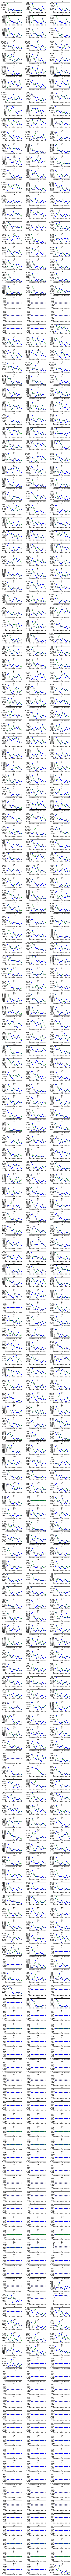

In [12]:
fig = plt.figure(figsize=(10,400))

#making 600 plots in for loop
#this takes time so you can just 
#use the loop to check which stations
#show a periodic trend annually (1/52 weeks)

periodicity = {}
 
for i in range(600):

    periodicity[i] = np.abs(np.fft.rfft(stations_np[i])[4])

  
    ax = fig.add_subplot(200,3,i)
    f = np.abs(np.fft.rfft(stations.loc[i,:]))
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f[1:]), 'o', ms = 8)
    ax.set_title('{0}'.format(i-1))
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f[1:]), '-')
    ax.set_xlim(0,1.0/15)
    plt.axvline(1.0/52, color='r')
    pl.subplots_adjust(wspace=.5, hspace=.5)
  

In [13]:
station_periodicity = sorted(periodicity.items(), key=operator.itemgetter(1))
print ('Stations with the 4 Highest Periodicity:\nFormat:(station number, value)\n\n', 
       station_periodicity[596:600])


Stations with the 4 Highest Periodicity:
Format:(station number, value)

 [(327, 2402218.5809588572), (150, 2931895.8769513383), (194, 2950388.929214194), (0, 2980160.6355953491)]
